***---------FP GROWTH---------***

In [648]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import fpcommon as fpc
import math
import itertools
import torch
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from itertools import combinations
from nltk.corpus import stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
print(stop_words)

{'only', 'themselves', 'its', 'won', 'haven', 'y', 'out', "won't", 'because', 'yours', "you're", 'this', 'she', 'don', 'from', 'weren', 'now', "wouldn't", 'has', 'then', 'they', "mustn't", 'having', 'for', 'wasn', 'off', 'just', 'as', 'other', 'between', 'during', 'there', 'been', 'before', 'same', 'once', 'when', 'ourselves', 'will', 'can', "hasn't", "should've", "haven't", 'up', 'ain', "needn't", 'we', 'herself', 'both', 'where', 'the', "mightn't", 'needn', "that'll", 'yourselves', 'by', 'how', 'a', 'himself', 'in', 'on', 'than', 'again', 's', 'nor', 'mightn', 'my', "don't", 'being', 'shan', 'hers', "wasn't", 'down', 'am', 'over', 'few', 've', "you've", 'mustn', 'no', 'about', 'his', 'until', 'them', 'aren', "shouldn't", 'theirs', 'but', 'or', 'didn', "didn't", 'he', 'so', "she's", 'our', 'into', 'o', 'through', 'him', 'wouldn', 'after', 'that', 'not', 'do', 'all', 'hasn', 'isn', 'those', 'doing', 'with', 'ours', 'ma', 'their', 'did', 'at', 'you', 'below', 'if', 'd', 'some', 'shouldn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [649]:
url = 'https://raw.githubusercontent.com/mohitgupta-1O1/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv'
df = pd.read_csv(url, encoding='latin1')

df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [650]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [651]:
missing_values = df.isnull().sum()

print(missing_values)

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


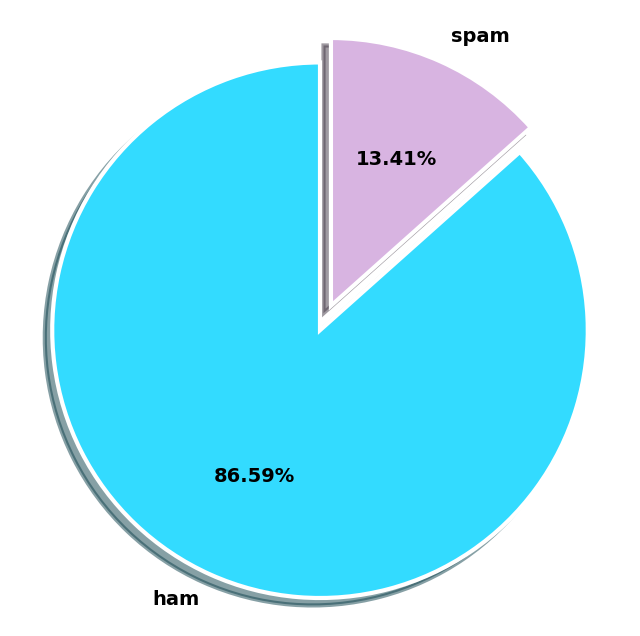

In [652]:
counts = df['v1'].value_counts()

colors = ['#33DBFF', '#D8B4E1']

explode = (0, 0.1)  

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('white')

wedges, texts, autotexts = ax.pie(
    counts, labels=['ham', 'spam'],
    autopct='%0.2f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 3, 'edgecolor': 'white'},
    explode=explode,  
    shadow=True  
)

for text, autotext in zip(texts, autotexts):
    text.set(size=14, weight='bold')
    autotext.set(size=14, weight='bold')

ax.axis('equal')

plt.show()

In [653]:
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

def clean_message(message):
    message = message.lower()
    message = re.sub(r'[^A-Za-z\s]', '', message)
    message = re.sub(r'\s+', ' ', message).strip()
    return message

df['message'] = df['message'].apply(clean_message)

df

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15744\1564774427.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['message'] = df['message'].apply(clean_message)


,label,message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final ...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...
...,...,...
5567,spam,this is the nd time we have tried contact u u ...
5568,ham,will b going to esplanade fr home
5569,ham,pity was in mood for that soany other suggestions
5570,ham,the guy did some bitching but i acted like id ...


In [654]:
df = df.drop_duplicates(keep = 'first')

df

,label,message
0,ham,go until jurong point crazy available only in ...
1,ham,ok lar joking wif u oni
2,spam,free entry in a wkly comp to win fa cup final ...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives aroun...
...,...,...
5567,spam,this is the nd time we have tried contact u u ...
5568,ham,will b going to esplanade fr home
5569,ham,pity was in mood for that soany other suggestions
5570,ham,the guy did some bitching but i acted like id ...


In [655]:
def remove_stopwords(message):
    words = message.split()
    return ' '.join([word for word in words if word.lower() not in stop_words])

df['message'] = df['message'].apply(remove_stopwords)

df

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15744\2893642738.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['message'] = df['message'].apply(remove_stopwords)


,label,message
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry wkly comp win fa cup final tkts st ...
3,ham,u dun say early hor u c already say
4,ham,nah dont think goes usf lives around though
...,...,...
5567,spam,nd time tried contact u u pound prize claim ea...
5568,ham,b going esplanade fr home
5569,ham,pity mood soany suggestions
5570,ham,guy bitching acted like id interested buying s...


In [656]:
encoder = LabelEncoder()
df['label'] = encoder.fit_transform(df['label'])

df

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_15744\1871698905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = encoder.fit_transform(df['label'])


,label,message
0,0,go jurong point crazy available bugis n great ...
1,0,ok lar joking wif u oni
2,1,free entry wkly comp win fa cup final tkts st ...
3,0,u dun say early hor u c already say
4,0,nah dont think goes usf lives around though
...,...,...
5567,1,nd time tried contact u u pound prize claim ea...
5568,0,b going esplanade fr home
5569,0,pity mood soany suggestions
5570,0,guy bitching acted like id interested buying s...


In [657]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=35)

train_df_sampled = train_df.sample(frac=0.1, random_state=3)
# train_df_sampled = train_df

spam_transactions_sampled = train_df_sampled[train_df_sampled['label'] == 1]['message'].str.split().tolist()
ham_transactions_sampled = train_df_sampled[train_df_sampled['label'] == 0]['message'].str.split().tolist()

# spam_transactions_sampled
# ham_transactions_sampled

In [658]:
unique_items = sorted(set(item for transaction in spam_transactions_sampled for item in transaction))
binary_matrix = [[1 if item in transaction else 0 for item in unique_items] for transaction in spam_transactions_sampled]
df_te_spam = pd.DataFrame(binary_matrix, columns=unique_items)

# df_te_spam

In [659]:
unique_items = sorted(set(item for transaction in ham_transactions_sampled for item in transaction))
binary_matrix = [[1 if item in transaction else 0 for item in unique_items] for transaction in ham_transactions_sampled]
df_te_ham = pd.DataFrame(binary_matrix, columns=unique_items)

# df_te_ham

***SELF-DEFINE FPGROWTH***

In [660]:
def Fpgrowth(df, min_support=0.5, use_colnames=False, max_len=None, verbose=0):
    colname_map = None
    if use_colnames:
        colname_map = {idx: item for idx, item in enumerate(df.columns)}

    tree, _ = fpc.setup_fptree(df, min_support)
    minsup = math.ceil(min_support * len(df.index)) 
    generator = fpg_step(tree, minsup, colname_map, max_len, verbose)

    return fpc.generate_itemsets(generator, len(df.index), colname_map)


def fpg_step(tree, minsup, colnames, max_len, verbose):
    count = 0
    items = tree.nodes.keys()
    if tree.is_path():
        size_remain = len(items) + 1
        if max_len:
            size_remain = max_len - len(tree.cond_items) + 1
        for i in range(1, size_remain):
            for itemset in itertools.combinations(items, i):
                count += 1
                support = min([tree.nodes[i][0].count for i in itemset])
                yield support, tree.cond_items + list(itemset)
    elif not max_len or max_len > len(tree.cond_items):
        for item in items:
            count += 1
            support = sum([node.count for node in tree.nodes[item]])
            yield support, tree.cond_items + [item]

    if verbose:
        tree.print_status(count, colnames)

    if not tree.is_path() and (not max_len or max_len > len(tree.cond_items)):
        for item in items:
            cond_tree = tree.conditional_tree(item, minsup)
            for sup, iset in fpg_step(cond_tree, minsup, colnames, max_len, verbose):
                yield sup, iset

In [661]:
frequent_itemsets_spam = Fpgrowth(df_te_spam, min_support=0.08, use_colnames=True)

frequent_itemsets_spam

,support,itemsets
0,0.357143,(call)
1,0.333333,(free)
2,0.261905,(txt)
3,0.166667,(stop)
4,0.142857,(win)
5,0.142857,(text)
6,0.095238,(entry)
7,0.119048,(phone)
8,0.166667,(ur)
9,0.119048,(awarded)


In [662]:
frequent_itemsets_ham = Fpgrowth(df_te_ham, min_support=0.01, use_colnames=True)

frequent_itemsets_ham

,support,itemsets
0,0.044586,(ltgt)
1,0.035032,(think)
2,0.012739,(say)
3,0.019108,(send)
4,0.057325,(love)
...,...,...
143,0.012739,"(wan, lor)"
144,0.012739,"(ill, get)"
145,0.012739,"(u, meet)"
146,0.025478,"(u, r)"


***SELF-DEFINE ASSOCIATION RULES***

In [663]:
def calculate_support(df, itemset):
    mask = df[itemset[0]] == 1
    for item in itemset[1:]:
        mask = mask & (df[item] == 1)
    return mask.sum() / len(df)

def generate_association_rules(frequent_itemsets, df, metric="confidence", min_threshold=0.05):
    rules = []
    for _, row in frequent_itemsets.iterrows():
        itemset = list(row['itemsets'])
        support = row['support']
        if len(itemset) > 1:
            for i in range(1, len(itemset)):
                for antecedent in combinations(itemset, i):
                    antecedent = list(antecedent)
                    consequent = list(set(itemset) - set(antecedent))
                    antecedent_support = calculate_support(df, antecedent)
                    consequent_support = calculate_support(df, consequent)
                    confidence = support / antecedent_support
                    if confidence >= min_threshold:
                        rules.append({
                            'antecedents': frozenset(antecedent),
                            'consequents': frozenset(consequent),
                            'antecedent support': antecedent_support,
                            'consequent support': consequent_support,
                            'support': support,
                            'confidence': confidence
                        })
    return pd.DataFrame(rules)

In [664]:
rules_spam = generate_association_rules(frequent_itemsets_spam, df_te_spam, metric="confidence", min_threshold=0.05)

rules_spam

,antecedents,consequents,antecedent support,consequent support,support,confidence
0,(free),(call),0.333333,0.357143,0.142857,0.428571
1,(call),(free),0.357143,0.333333,0.142857,0.400000
2,(free),(txt),0.333333,0.261905,0.095238,0.285714
3,(txt),(free),0.261905,0.333333,0.095238,0.363636
4,(stop),(txt),0.166667,0.261905,0.119048,0.714286
5,(txt),(stop),0.261905,0.166667,0.119048,0.454545
6,(text),(free),0.142857,0.333333,0.095238,0.666667
7,(free),(text),0.333333,0.142857,0.095238,0.285714
8,(entry),(free),0.095238,0.333333,0.095238,1.000000
9,(free),(entry),0.333333,0.095238,0.095238,0.285714


In [665]:
rules_ham = generate_association_rules(frequent_itemsets_ham, df_te_ham, metric="confidence", min_threshold=0.05)

rules_ham

,antecedents,consequents,antecedent support,consequent support,support,confidence
0,(u),(come),0.143312,0.044586,0.012739,0.088889
1,(come),(u),0.044586,0.143312,0.012739,0.285714
2,(night),(know),0.035032,0.050955,0.012739,0.363636
3,(know),(night),0.050955,0.035032,0.012739,0.250000
4,(u),(im),0.143312,0.070064,0.022293,0.155556
5,(im),(u),0.070064,0.143312,0.022293,0.318182
6,(u),(good),0.143312,0.041401,0.012739,0.088889
7,(good),(u),0.041401,0.143312,0.012739,0.307692
8,(home),(come),0.041401,0.044586,0.012739,0.307692
9,(come),(home),0.044586,0.041401,0.012739,0.285714


In [666]:
def classify_message(message, rules_spam, rules_ham):
    message_set = set(message.split())

    spam_score = 0
    ham_score = 0

    for _, rule in rules_spam.iterrows():
        if set(rule['antecedents']).issubset(message_set):
            spam_score += rule['confidence']

    for _, rule in rules_ham.iterrows():
        if set(rule['antecedents']).issubset(message_set):
            ham_score += rule['confidence']

    if spam_score > ham_score:
        return 1
    else:
        return 0

test_df['predicted'] = test_df['message'].apply(lambda x: classify_message(x, rules_spam, rules_ham))

accuracy_test = accuracy_score(test_df['label'], test_df['predicted'])
print(f'Accuracy: {accuracy_test}')

print(classification_report(test_df['label'], test_df['predicted']))

labels = torch.tensor(test_df['label'].values, dtype=torch.float32)
preds = torch.tensor(test_df['predicted'].values, dtype=torch.float32)
loss = F.binary_cross_entropy_with_logits(preds, labels)
print(f'Cross-Entropy Loss: {loss.item()}')

Accuracy: 0.9064136125654451
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      1344
           1       0.59      0.70      0.64       184

    accuracy                           0.91      1528
   macro avg       0.78      0.82      0.79      1528
weighted avg       0.91      0.91      0.91      1528

Cross-Entropy Loss: 0.6967891454696655


Self-made mail

In [667]:
#spam - incorrect
message = clean_message("You have been chosen for a trial for our new weight loss product. Lose 10 kgs in a week. Click here to buy now!!")
message = remove_stopwords(message)
result = classify_message(message, rules_spam, rules_ham)
print(result)

0


In [668]:
#spam - correct
message = clean_message("GET RICH TODAY! No investment. No hard work. Earn $10,000 a week. Click here for awarded NOW")
message = remove_stopwords(message)
result = classify_message(message, rules_spam, rules_ham)
print(result)

1


Mail from another Dataset

In [669]:
#spam - incorrect
message = clean_message("Do you owe money? [pdp10a] Do you owe money? Is it getting troublesome keeping track of all those bills and whom you owe how much and when? Would it not be easier if you could just make 1 monthly payment instead of several? We can help! If your debts are $4,000 US or more and you are a United States citizen, you can consolidate your debt into just one easy payment! You do not have to own a home, nor do you need to take out a loan. Credit checks are not required! To receive more information regarding our services, please fill out the form below and return it to us, or provide the necessary information in your response. There are absolutely no obligations. All the fields below are required for your application to be processed. Full Name Address City State Zip Code Home Phone Work Phone Best Time to Call E-Mail Address Estimated Debt Size Please allow upto ten business days for application processing. Thank You Note: If this e-mail arrived to you by error, or you wish to never receive such advertisements from our company, please reply to this e-mail with the word REMOVE in the e-mail subject line. We apologize for any inconveniences ls2fd8x")
message = remove_stopwords(message)
result = classify_message(message, rules_spam, rules_ham)
print(result)

0


In [670]:
#spam - correct
message = clean_message("Welcome to Qpass! Greetings from Qpass: Thank you for registering with Qpass, the safe and easy way to buy digital content, goods, and services on the Web. You are receiving this message because you just registered with Qpass, or one of the many Qpass-enabled Web sites, a list of which is viewable by clicking below: <URL> As a Qpass user, you can now buy from any Qpass-enabled Web site using your same User Name and password. Any purchases you make will be billed to your selected credit card on a monthly basis. VIEW AND MANAGE YOUR QPASS ACCOUNT My Qpass (<URL> is your online support center. It's available 24 hours a day, seven days a week and best of all, it's free! At My Qpass, you can: Review a summary of all your purchases in one convenient location Update your billing information Get online customer support QUESTIONS ABOUT QPASS? Visit our FAQ page: <URL> Review our Privacy Policy: <URL> DIGITAL CONTENT A WORLD OF GOODS AND SERVICES FOR YOU There's an incredible variety of useful information, fun products, and handy services available on the Web today! As a Qpass user, you can purchase eMinutes from AT&T Wireless, a day's access to The Wall Street Journal Online, articles from the archives of The New York Times on the Web, mutual fund reports from Morningstar, and more. Thank you again for registering with Qpass. We hope you enjoy your safe and easy access to premium digital products and services. Best Regards, Qpass Customer Service")
message = remove_stopwords(message)
result = classify_message(message, rules_spam, rules_ham)
print(result)

1


In [671]:
#ham - incorrect
message = clean_message("Mark, Good Afternoon! you have 258 shares being vested in Jan 2002. It is too early to tell what the taxes will be, I'm sure we'll be notified before the release date. Thank You! Best, Joe Vazquez Financial Advisor UBSPaineWebber Inc. 1111 Bagby St. Suite 5100 Houston, Tx. 77002 713-654-4727 800-553-3119 Toll 713-654-1281 Fax joe.vazquez@ubspainewebber.com Notice Regarding Entry of Orders and Instructions: Please do not transmit orders and/or instructions regarding your UBSPaineWebber account(s) by e-mail. Orders and/or instructions transmitted by e-mail will not be accepted by UBSPaineWebber and UBSPaineWebber will not be responsible for carrying out such orders and/or instructions. Notice Regarding Confirmation: Please be advised that this e-mail is not an official transaction confirmation. The only official confirmation of a transaction will be sent to you via regular mail. Notice Regarding Privacy and Confidentiality: UBSPaineWebber reserves the right to monitor and review the content of all e-mail communications sent and/or received by its employees.")
message = remove_stopwords(message)
result = classify_message(message, rules_spam, rules_ham)
print(result)

1


In [672]:
#ham - corect
message = clean_message("RE: New York These are the events that took place concerning the New York Customer Holiday Event: In order to reserve rooms for the first weekend in NY at the Four Seasons, I have to book no later than 9 months out. To hold these rooms, a contract had to be signed and a $15,000 deposit sent. The contract allowed us to cancel the entire event by the end of July with no penalty and the deposit was fully refundable. In speaking with Dave Duran and Frank Vickers in May, they wanted to proceed with this event. Attached is a memo that I sent to Frank Vickers outlining the cancellation policy.) The cost estimate went through several revisions and the final was sent to you for your approval in July. After the approval form was rejected, I spoke with Dave Duran and he was planning to revise his guest list and re-submit the approval form. I talked to both Frank and Dave numerous times and reminded them of the hotel penalty issues and had not heard back from either one until I received an e-mail on September 20th from Frank canceling his portion of the trip. I called my Four Seasons national sales rep and she is working with NY in canceling the contract and minimizing the hotel liquidated damages. I should have an answer from her no later than tomorrow. Please let me know if you would like to discuss this in more detail. Thanks. To: Hitchcock, Dorie")
message = remove_stopwords(message)
result = classify_message(message, rules_spam, rules_ham)
print(result)

0


***---------MULTINOMIAL NAIVE BAYES---------***

In [673]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

url = 'https://raw.githubusercontent.com/mohitgupta-1O1/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv'
df = pd.read_csv(url, encoding='latin1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

def clean_message(message):
    message = message.lower()
    message = re.sub(r'[^A-Za-z\s]', '', message)
    message = re.sub(r'\s+', ' ', message).strip()
    return message

df['message'] = df['message'].apply(clean_message)

df = df.drop_duplicates(keep='first')

def remove_stopwords(message):
    words = message.split()
    return ' '.join([word for word in words if word.lower() not in stop_words])

df['message'] = df['message'].apply(remove_stopwords)

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['message'])
y = df['label'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35)

model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
y_pred_proba = model.predict_proba(X_test)[:, 1] 
y_pred_proba_tensor = torch.tensor(y_pred_proba, dtype=torch.float32)

loss = F.binary_cross_entropy(y_pred_proba_tensor, y_test_tensor)
print(f'Cross Entropy Loss: {loss.item()}')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.9640052356020943
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1344
           1       0.82      0.90      0.86       184

    accuracy                           0.96      1528
   macro avg       0.90      0.93      0.92      1528
weighted avg       0.97      0.96      0.96      1528

Cross Entropy Loss: 0.1526740938425064


***---------LOGISTIC REGRESSION---------***

In [674]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn.functional as F
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

url = 'https://raw.githubusercontent.com/mohitgupta-1O1/Kaggle-SMS-Spam-Collection-Dataset-/master/spam.csv'
df = pd.read_csv(url, encoding='latin1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']

def clean_message(message):
    message = message.lower()
    message = re.sub(r'[^A-Za-z\s]', '', message)
    message = re.sub(r'\s+', ' ', message).strip()
    return message

df['message'] = df['message'].apply(clean_message)

df = df.drop_duplicates(keep = 'first')

def remove_stopwords(message):
    words = message.split()
    return ' '.join([word for word in words if word.lower() not in stop_words])

df['message'] = df['message'].apply(remove_stopwords)

vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['message'])

y = df['label'].map({'ham': 0, 'spam' : 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

# Tính toán Cross Entropy Loss
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Xác suất dự đoán cho nhãn 1 (spam)
y_pred_proba_tensor = torch.tensor(y_pred_proba, dtype=torch.float32)

loss = F.binary_cross_entropy(y_pred_proba_tensor, y_test_tensor)
print(f'Cross Entropy Loss: {loss.item()}')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.9725130890052356
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1344
           1       1.00      0.77      0.87       184

    accuracy                           0.97      1528
   macro avg       0.98      0.89      0.93      1528
weighted avg       0.97      0.97      0.97      1528

Cross Entropy Loss: 0.0913788229227066
